Dataset Loaded. Cleaned Training Samples: 8599
Class Distribution in Test Set: [1083    6]

========== Executing Baseline: Logistic Regression ==========
                       precision    recall  f1-score   support

        Non-Habitable       1.00      0.99      0.99      1083
Potentially Habitable       0.16      0.50      0.24         6

             accuracy                           0.98      1089
            macro avg       0.58      0.74      0.62      1089
         weighted avg       0.99      0.98      0.99      1089



<Figure size 1000x700 with 0 Axes>

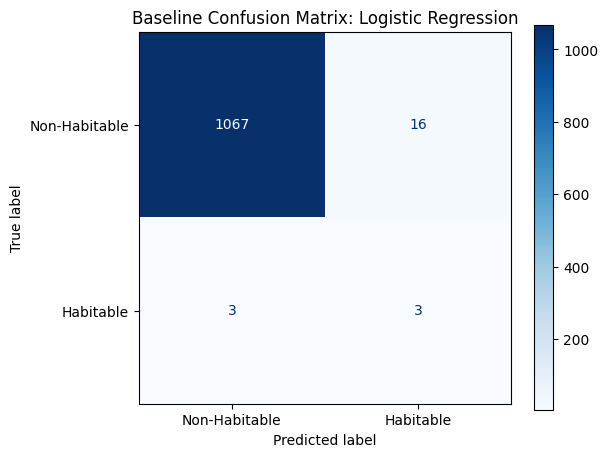


========== Executing Baseline: Shallow Decision Tree ==========
                       precision    recall  f1-score   support

        Non-Habitable       1.00      0.99      0.99      1083
Potentially Habitable       0.20      0.50      0.29         6

             accuracy                           0.99      1089
            macro avg       0.60      0.74      0.64      1089
         weighted avg       0.99      0.99      0.99      1089



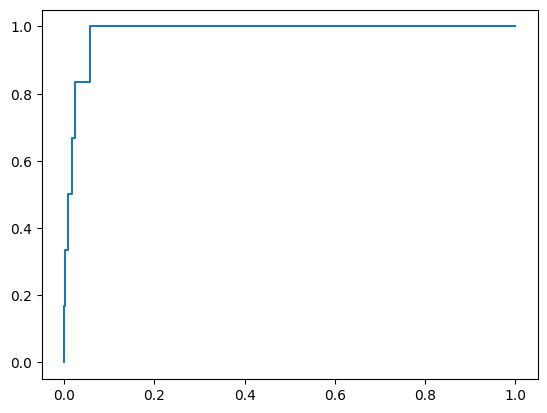

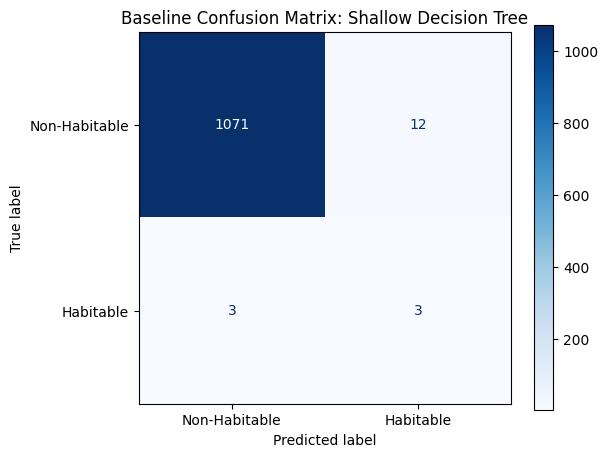

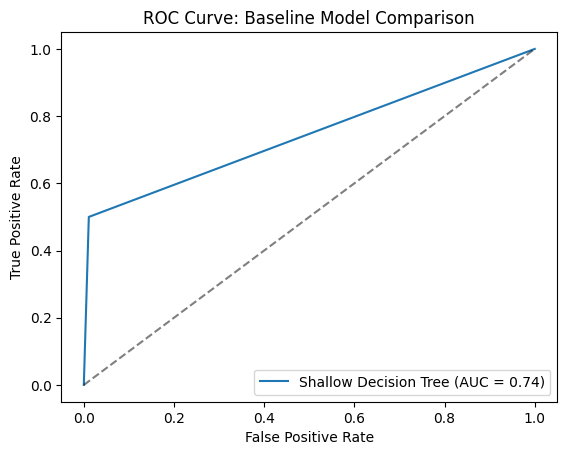


FINAL BASELINE BENCHMARKS (REFERENCE)
                Model  Accuracy  Precision  Recall  F1-Score  F2-Score
Shallow Decision Tree  0.986226   0.200000     0.5  0.285714  0.384615
  Logistic Regression  0.982553   0.157895     0.5  0.240000  0.348837


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score, 
    recall_score,
    precision_score,
    f1_score,
    fbeta_score, # For our new F2-score target
    roc_curve,   # Mandatory Output
    auc          # Mandatory Output
)

# 1. LOAD PREPARED DATA
# These files now contain the cleaned SMOTE-ENN samples
X_train = pd.read_csv('X_train_final.csv')
y_train = pd.read_csv('y_train_final.csv').values.ravel()
X_test = pd.read_csv('X_test_final.csv')

# Binarizing the test target (Threshold 0.7 matches Milestone 3 logic)
y_test_cont = pd.read_csv('y_test_final.csv').values.ravel()
y_test = (y_test_cont > 0.7).astype(int)

print(f"Dataset Loaded. Cleaned Training Samples: {len(X_train)}")
print(f"Class Distribution in Test Set: {np.bincount(y_test)}")

# 2. INITIALIZE BASELINE PIPELINES [cite: 53]
# Logistic Regression: Linear Baseline
log_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# Shallow Decision Tree: Non-linear Baseline (max_depth=3 to prevent early overfitting)
tree_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced'))
])

# 3. TRAINING AND HYBRID EVALUATION
baselines = {
    "Logistic Regression": log_reg_pipe,
    "Shallow Decision Tree": tree_pipe
}

results = []
plt.figure(figsize=(10, 7)) # For Mandatory ROC Curve comparison

for name, pipe in baselines.items():
    print(f"\n{'='*10} Executing Baseline: {name} {'='*10}")
    
    # Model Fitting [cite: 60]
    pipe.fit(X_train, y_train)
    
    # Model Predictions
    y_pred = pipe.predict(X_test)
    y_probs = pipe.predict_proba(X_test)[:, 1] # Probability for ROC-AUC [cite: 69]
    
    # Metric Calculation including F2-Score (Recall weight = 2)
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0),
        "F2-Score": fbeta_score(y_test, y_pred, beta=2, zero_division=0)
    }
    results.append(metrics)
    
    # Mandatory Output: Classification Report [cite: 72]
    print(classification_report(y_test, y_pred, target_names=['Non-Habitable', 'Potentially Habitable']))
    
    # Mandatory Output: Confusion Matrix [cite: 71]
    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_pred, 
        display_labels=['Non-Habitable', 'Habitable'], 
        cmap='Blues', 
        ax=ax
    )
    plt.title(f"Baseline Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

    # Mandatory Output: ROC Curve Generation [cite: 73]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Finalizing Mandatory ROC Plot [cite: 73]
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Baseline Model Comparison')
plt.legend(loc='lower right')
plt.show()

# 4. FINAL BASELINE BENCHMARK SUMMARY [cite: 34, 35]
baseline_df = pd.DataFrame(results)
print("\n" + "="*40)
print("FINAL BASELINE BENCHMARKS (REFERENCE)")
print("="*40)
print(baseline_df.sort_values(by='F2-Score', ascending=False).to_string(index=False))